In [170]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from torch.nn.functional import cosine_similarity, interpolate
from torchvision import datasets
from torchvision.transforms import v2 as T
from IPython.display import clear_output
from scipy import stats
import random

In [171]:
seed = 0
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True, warn_only=True)


def set_seed(seed_=seed):
    random.seed(seed_)
    np.random.seed(seed_)
    torch.manual_seed(seed_)
    torch.cuda.manual_seed(seed_)
    torch.cuda.manual_seed_all(seed_)


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

Цель исследования, найти наиболее сильную архитектуру автоенкодера по сравнению с текущей версией.

Чем больше эмбеддинги одного класса отличаются от эмбеддингов другого класса, тем лучше. Сходство двух эмбеддингов будем проверять через косинусное подобие $cossim(a, b)$.

$ y = \sum_{i=1} ^{N} cossim(A1_i, A2_i) - cossim(A_i, B_i) $

где:
- $A1, A2$ - множество объектов одного класса. $ A1 \neq A2 $ 
- $B$ - множество объектов отличных от класса объектов в множестве $A1$

Проверять силу модели относительно текущей версии будем с использованием статистических критериев.

## Загрузим данные для обучения

In [172]:
caltech101 = datasets.Caltech101(
    root='test_data/caltech101/',
    target_type='category',
    transform=T.Compose([
        T.Resize((192, 192)),
        T.ToTensor(),
        T.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
    ]),
    download=True
)

Files already downloaded and verified


In [173]:
valid_images = []
airplanes = []
already_taken = []
for image in caltech101:
    if len(already_taken) == 100:
        break
    if image[1] == 5:
        airplanes.append(image[0])
    elif image[1] not in already_taken:
        valid_images.append(image[0])
        already_taken.append(image[1])

len(valid_images), len(airplanes)

(100, 800)

In [174]:
set_seed()

valid_airplanes = random.sample(airplanes, 100)
airplanes = list(set(airplanes) - set(valid_airplanes))
len(valid_airplanes), len(airplanes)

(100, 700)

## Построим модель текущей версии

In [175]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [176]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3, 3), padding=1, stride=1, is_last=False, is_up=False):
        super().__init__()
        self.in_channels, self.out_channels = in_channels, out_channels
        self.kernel_size = kernel_size,
        self.padding = padding,
        self.stride = stride
        self.is_last = is_last
        self.is_up = is_up
        self.conv = nn.Conv2d(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=self.kernel_size[0],
            padding=self.padding,
            stride=self.stride
        )
        self.normalization = nn.BatchNorm2d(num_features=self.out_channels)
        self.act = nn.ReLU()

    def forward(self, x):
        if self.is_up:
            x = interpolate(x, scale_factor=2, mode='bilinear', recompute_scale_factor=False)

        x = self.conv(x)

        if not self.is_last:
            x = self.normalization(x)
            x = self.act(x)
        
        return x



class AutoencoderModel(nn.Module):
    def __init__(self, base_channels=8):
        super().__init__()
        self.base_channels = base_channels
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()
        self.encoder = nn.Sequential(
            # first layer
            ConvBlock(3, self.base_channels, kernel_size=(5, 5), padding=2),
            ConvBlock(self.base_channels, self.base_channels, kernel_size=(5, 5), padding=2),
            ConvBlock(self.base_channels, self.base_channels),
            nn.MaxPool2d(kernel_size=(2, 2)),

            # second layer
            ConvBlock(self.base_channels, self.base_channels * 2),
            ConvBlock(self.base_channels * 2, self.base_channels * 2),
            ConvBlock(self.base_channels * 2, self.base_channels * 2),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.decoder = nn.Sequential(
            ConvBlock(in_channels=self.base_channels * 2, out_channels=self.base_channels, is_up=True),
            ConvBlock(in_channels=self.base_channels, out_channels=3, is_last=True, is_up=True),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.sigmoid(x)
        return x

    @torch.inference_mode()
    def encode(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        return x

In [177]:
def train(model, data_loader, optimizer, loss_fn):
    model.to(DEVICE)
    model.train()

    train_loss = []
    for x in data_loader:
        x = x.to(DEVICE)
        optimizer.zero_grad()

        out = model(x)
        loss = loss_fn(out, x)
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()

    return np.mean(train_loss)


@torch.inference_mode()
def evaluate(model, data_loader, loss_fn):
    model.to(DEVICE)
    model.eval()

    evalute_loss = []
    for x in data_loader:
        x = x.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, x)
        evalute_loss.append(loss.item())

    return np.mean(evalute_loss)


def epoch_train(model, train_data_loader, test_data_loader, optimizer, loss_fn, num_epoch, plot=True):
    train_loss, test_loss = [], []

    for _ in range(1, num_epoch + 1):
        train_out = train(model, train_data_loader, optimizer, loss_fn)
        test_out = evaluate(model, test_data_loader, loss_fn)
        train_loss.append(train_out)
        test_loss.append(test_out)

        if plot:
            clear_output(wait=True)
            plt.plot(train_loss, color='blue', marker="o", alpha=0.5)
            plt.plot(test_loss, color='green', marker="^", alpha=0.5)
            plt.legend(['train', 'test'])
            plt.show()

In [178]:
def get_cosine_similarity(model, first_data, secod_data):
    result = cosine_similarity(
            model.encode(torch.stack(first_data).to(DEVICE)).cpu(),
            model.encode(torch.stack(secod_data).to(DEVICE)).cpu()
        )
    return [x.item() for x in result]

def shift_objects_in_list(data, shift):
    data_ = data[shift:]
    data_.extend(data[:shift])
    return data_

In [179]:
def plot_model_in_out_comparison(in_image, out_image):
    image = np.einsum('cwh->whc', in_image.detach().numpy())
    out = np.einsum('cwh->whc', out_image.detach().numpy())

    _, ax = plt.subplots(1, 2, figsize=(4, 4))
    ax[0].imshow(image)
    ax[1].imshow(out)

    plt.show()


def plot_similarity(a, b, title):
    plt.figure(figsize=(12, 4))
    sns.histplot((a, b), kde=True,  bins=50, alpha=0.5)
    plt.xlim(0, 1)
    plt.legend(
        [f'mean cossim(A1, A2): {round(np.mean(a) * 100, 2)}%',
         f'mean cossim(A1, B): {round(np.mean(b) * 100, 2)}%',
         'cossim(A1, B)',
         'cossim(A1, A2)',
         ],
        title=f'diff between mean samples: {round((np.mean(a) - np.mean(b))* 100, 2)} pp'
    )
    plt.axvline(x=np.mean(a), alpha=1, color='blue')
    plt.axvline(x=np.mean(b), alpha=1, color='red')
    ax = plt.gca()
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('blue')
    leg.legendHandles[1].set_color('red')
    if title:
        plt.title(title)
    plt.show()

In [180]:
set_seed()

model = AutoencoderModel()
model.to(DEVICE)
optimizer = Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
num_epoch = 15

train_data, test_data = random_split(torch.stack(airplanes), (0.8, 0.2))
train_data_loader = DataLoader(dataset=train_data, batch_size=20, shuffle=True, pin_memory=True, worker_init_fn=seed_worker)
test_data_loader = DataLoader(dataset=test_data, batch_size=20, shuffle=True, pin_memory=True, worker_init_fn=seed_worker)

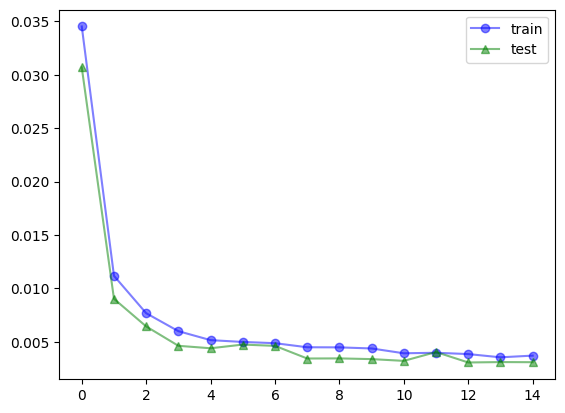

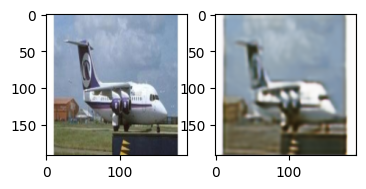

In [181]:
epoch_train(model, train_data_loader, test_data_loader, optimizer, loss_fn, num_epoch)
plot_model_in_out_comparison(train_data[0], model(train_data[0].unsqueeze(0).to(DEVICE))[0].cpu())

Убедимся в том, что объекты из А1 больше похожи на объекты А2, чем В. Построим график распределений косинусного подобия А1-А2 и А1-B.

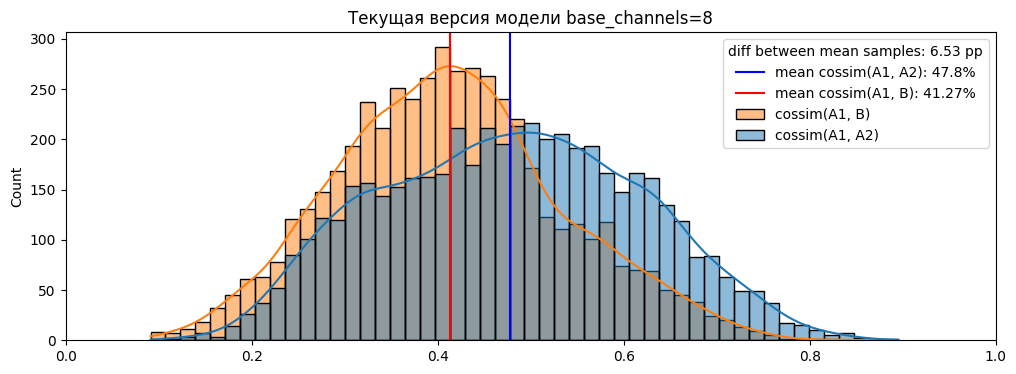

In [182]:
model.eval()

a_a_sim, a_b_sim = [], []
for i in range(1, 51):
    a_a_sim.extend(get_cosine_similarity(model, valid_airplanes, shift_objects_in_list(valid_airplanes, i)))
    a_b_sim.extend(get_cosine_similarity(model, valid_airplanes, shift_objects_in_list(valid_images, i)))

plot_similarity(
    a_a_sim,
    a_b_sim,
    title='Текущая версия модели base_channels=8'
)

Проверим гомогенность дисперсий в группах с помощью теста Левена

In [183]:
print(f'p-value {stats.levene(a_a_sim, a_b_sim).pvalue}')

p-value 1.8331133099092942e-34


Так как p-value меньше 0.05, мы не можеми применить t-критерий Стьюдента, поэтому будем применять t-критерий Уэлча

- H0 - косинусное подобие А1-А2 не отличется от А1-В
- H1 - косинусное подобие А1-А2 отличется от А1-В
- Уровень значимости 0.05

In [184]:
result = stats.ttest_ind(a_a_sim, a_b_sim, equal_var=True)
print(f'p-value: {result.pvalue}')

p-value: 3.9560263519766705e-135


p-value меньше 0.05, а значит мы можем отклонить нулевую гипотезу о том, что эти выборки одинаковые.

## Теперь построим новые модели автоенкодеров 

Добавим линейный слой в bottleneck вместо растягивания сверточного слоя.

In [185]:
class NewAutoencoderModel(nn.Module):
    def __init__(self, base_channels=8, bottleneck_size=200):
        super().__init__()
        self.base_channels = base_channels
        self.bottleneck_size = bottleneck_size
        self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2))
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()
        self.encoder = nn.Sequential(
            # first layer
            ConvBlock(3, self.base_channels, kernel_size=(5, 5), padding=2),
            ConvBlock(self.base_channels, self.base_channels, kernel_size=(5, 5), padding=2),
            ConvBlock(self.base_channels, self.base_channels),
            nn.MaxPool2d(kernel_size=(2, 2)),

            # second layer
            ConvBlock(self.base_channels, self.base_channels * 2),
            ConvBlock(self.base_channels * 2, self.base_channels * 2),
            ConvBlock(self.base_channels * 2, self.base_channels * 2),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.linear_1 = nn.Sequential(
            self.flatten,
            nn.Linear(self.base_channels * 2 * 48 * 48, self.bottleneck_size),
            nn.ReLU(),
        )
        self.linear_2 = nn.Sequential(
            nn.Linear(self.bottleneck_size, self.base_channels * 2 * 48 * 48),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            ConvBlock(in_channels=self.base_channels * 2, out_channels=self.base_channels, is_up=True),
            ConvBlock(in_channels=self.base_channels, out_channels=3, is_last=True, is_up=True),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.linear_1(x)
        x = self.linear_2(x)
        x = x.view(-1, self.base_channels * 2, 48, 48)
        x = self.decoder(x)
        x = self.sigmoid(x)
        return x

    @torch.no_grad()
    def encode(self, x):
        x = self.encoder(x)
        x = self.linear_1(x)
        return x

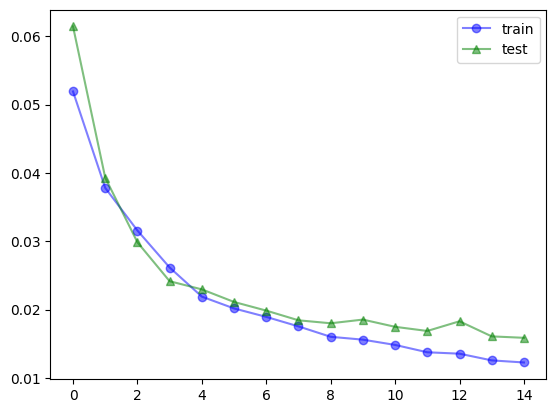

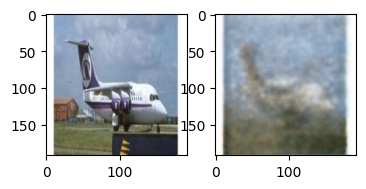

In [186]:
set_seed()

new_model = NewAutoencoderModel(bottleneck_size=400)
optimizer = Adam(new_model.parameters(), lr=1e-3)
new_model.to(DEVICE)

epoch_train(new_model, train_data_loader, test_data_loader, optimizer, loss_fn, num_epoch)
plot_model_in_out_comparison(train_data[0], new_model(train_data[0].unsqueeze(0).to(DEVICE))[0].cpu())

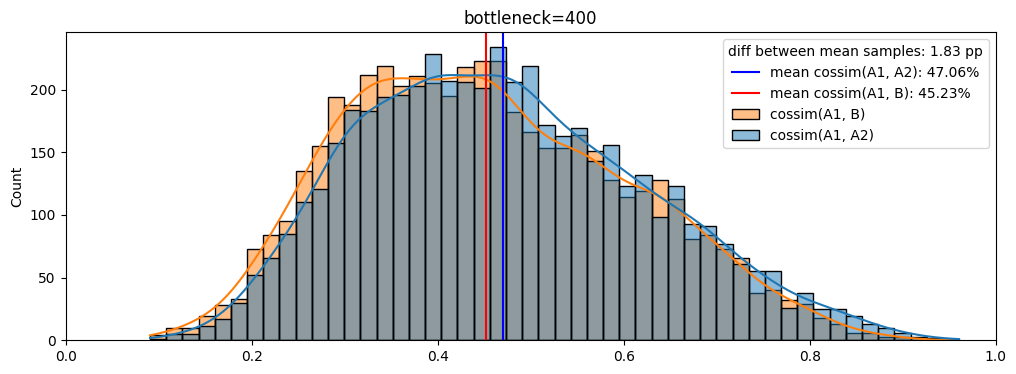

Welch p-value: 1.8526911370893047e-09


In [187]:
new_model.eval()

a_a_sim, a_b_sim = [], []
for i in range(1, 51):
    a_a_sim.extend(get_cosine_similarity(new_model, valid_airplanes, shift_objects_in_list(valid_airplanes, i)))
    a_b_sim.extend(get_cosine_similarity(new_model, valid_airplanes, shift_objects_in_list(valid_images, i)))

plot_similarity(
    a_a_sim,
    a_b_sim,
    title='bottleneck=400'
)
welch = stats.ttest_ind(a_a_sim, a_b_sim, equal_var=True)
print(f'Welch p-value: {welch.pvalue}')

Распределения сместились в левую сторону, появился правый хвост. 

Попробуем увеличить количество нейронов в линейном слое: 800, 1600, 3200.

In [188]:
def train_and_plot(model, plot_title, plot=True):
    optimizer = Adam(model.parameters(), lr=1e-3)
    model.to(DEVICE)

    epoch_train(model, train_data_loader, test_data_loader, optimizer, loss_fn, num_epoch, plot=False)

    model.eval()

    a_a_sim, a_b_sim = [], []
    for i in range(1, 51):
        a_a_sim.extend(get_cosine_similarity(model, valid_airplanes, shift_objects_in_list(valid_airplanes, i)))
        a_b_sim.extend(get_cosine_similarity(model, valid_airplanes, shift_objects_in_list(valid_images, i)))

    if plot:
        plot_similarity(
            a_a_sim,
            a_b_sim,
            title=plot_title
        )
        welch = stats.ttest_ind(a_a_sim, a_b_sim, equal_var=True)
        print(f'Welch p-value: {welch.pvalue}')

    return a_a_sim, a_b_sim

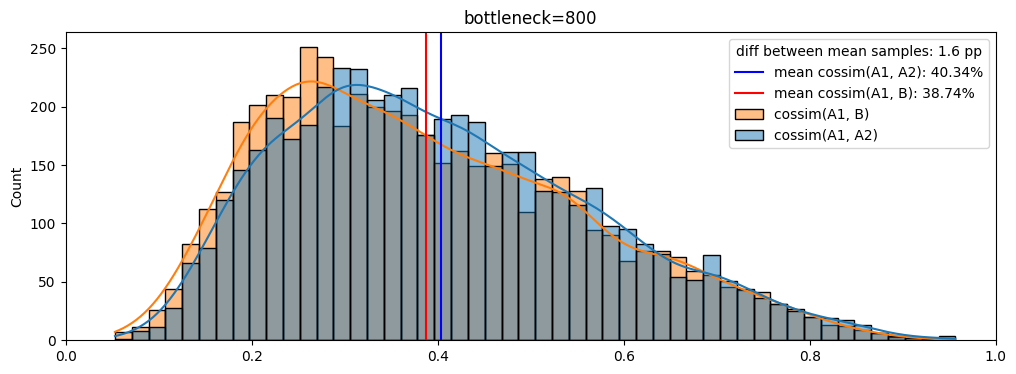

Welch p-value: 1.7564218600837096e-06


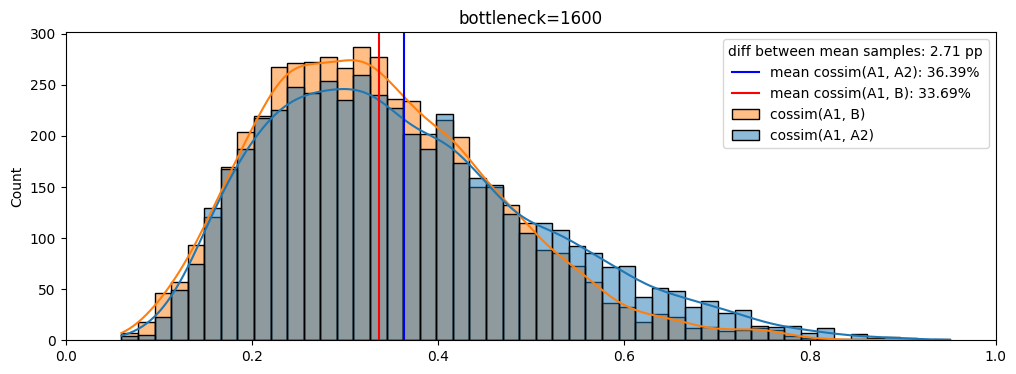

Welch p-value: 2.2907632412269503e-22


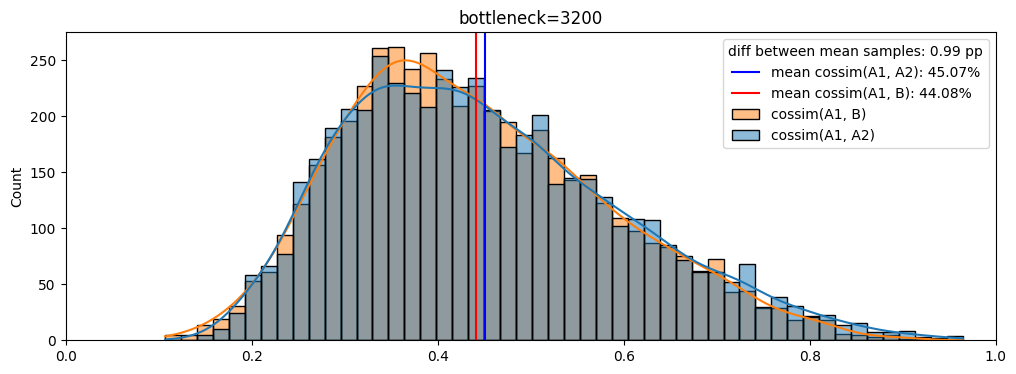

Welch p-value: 0.0006420926993115193


In [189]:
set_seed()

for size in [800, 1600, 3200]:
    train_and_plot(NewAutoencoderModel(bottleneck_size=size), f'bottleneck={size}')

При увеличении числа нейронов в линейном слое правый хвост увеличивается, но при этом значительно увеличивается время обучения модели. Таким образом, линейный слой не дает более хороших результатов по сравнению с простым растягиванием сверточного слоя. 

Попробуем изменить количество каналов сверток.

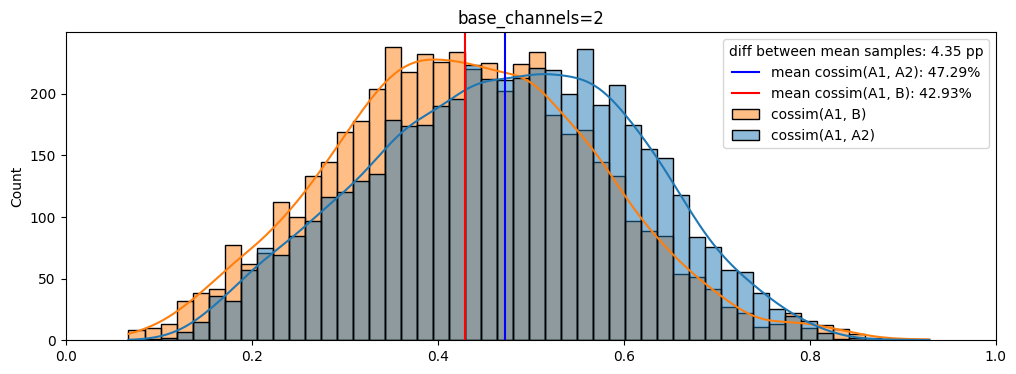

Welch p-value: 8.07144047705635e-53


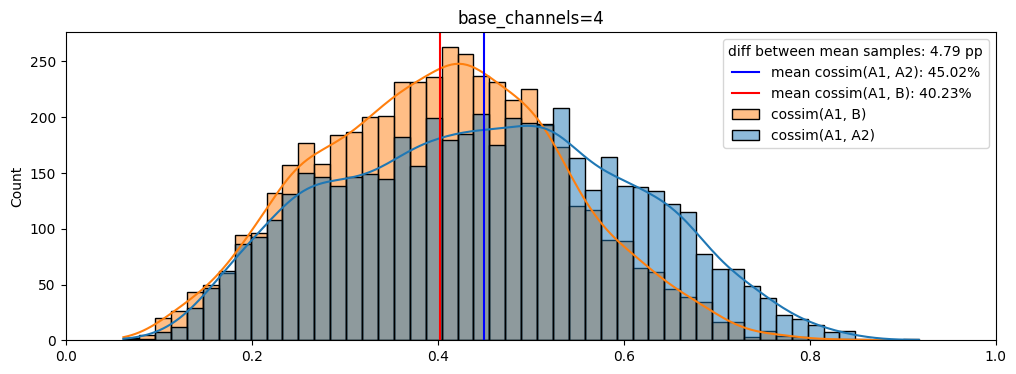

Welch p-value: 1.1884556197051145e-61


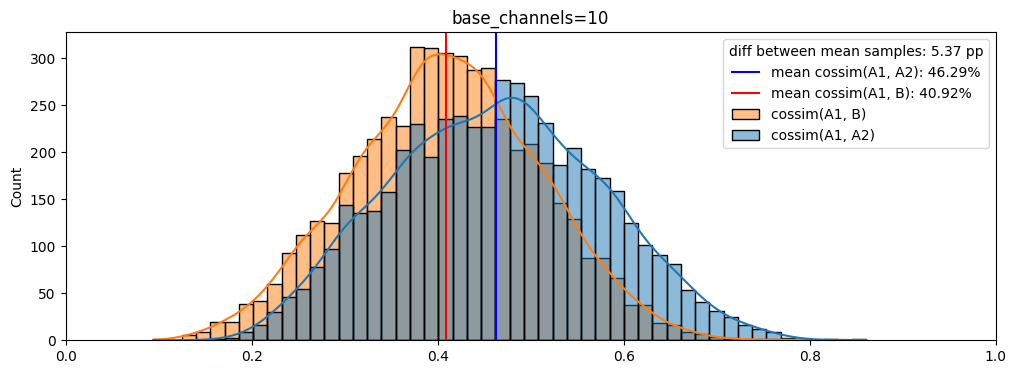

Welch p-value: 4.4825548514755297e-135


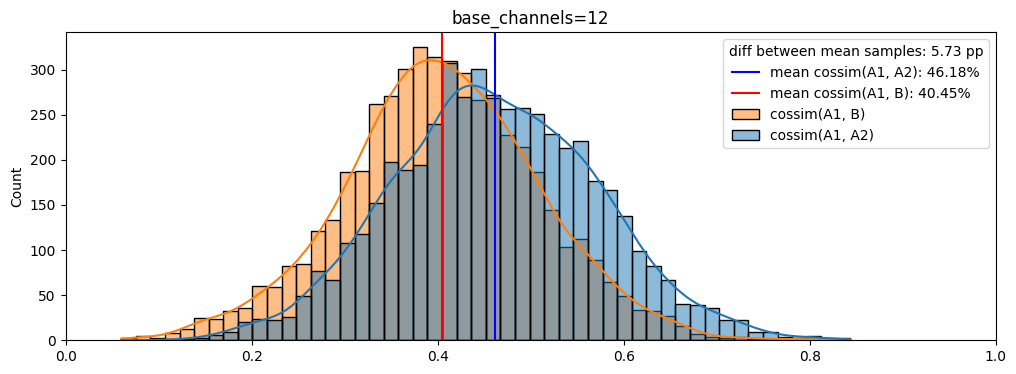

Welch p-value: 4.201931248669442e-152


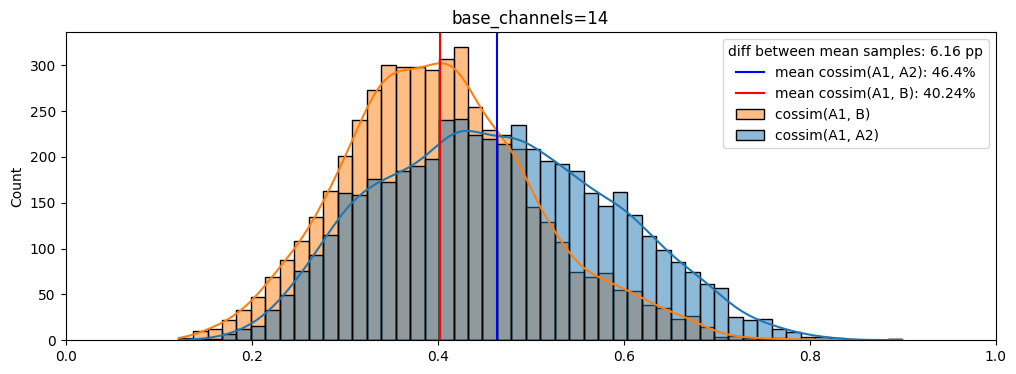

Welch p-value: 3.718675053560306e-154


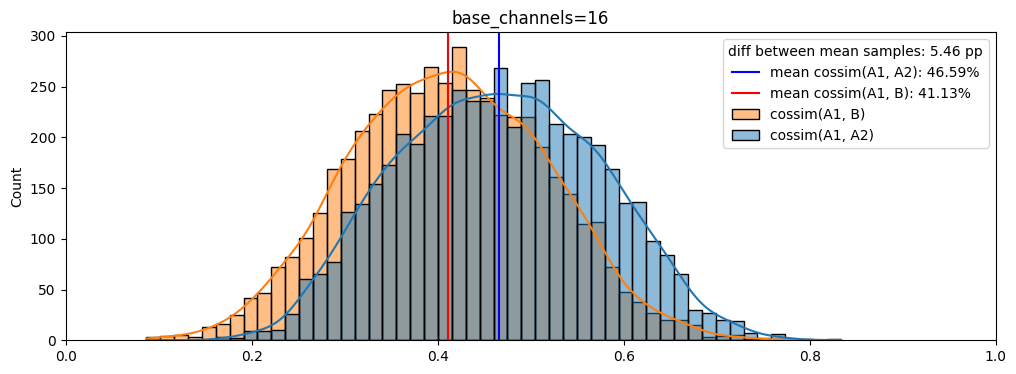

Welch p-value: 3.289180394023155e-141


In [190]:
set_seed()

results = {}
for channels in [2, 4, 10, 12, 14, 16]:
    model_result = train_and_plot(AutoencoderModel(base_channels=channels), f'base_channels={channels}')
    results.update({channels: model_result})

Глядя на графики, можно предположить, что с увеличением числа каналов разница между А1-А2 и А1-B почти не изменяется, а при уменьшении числа каналов разница между А1-А2 и А1-B становится еще меньше.

Как итог, можно сделать вывод, что не удалось найти более сильную архитектуру автоенкодера. Стоит перейти от обучения без учителя к обучению с учителем.